# Практическое задание к уроку 3

### Обучить СНС с помощью Transfer Learning на датасете Food-101
### Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.
### Библиотеки: [Python, Tensorflow]

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

#### Загрузка датасета

In [233]:
(train_ds, test_ds), ds_info = tfds.load('food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

In [234]:
num_classes = ds_info.features['label'].num_classes
print(num_classes)

101


In [235]:
classes_name=np.loadtxt(ds_info.data_dir+'//label.labels.txt',dtype='str')

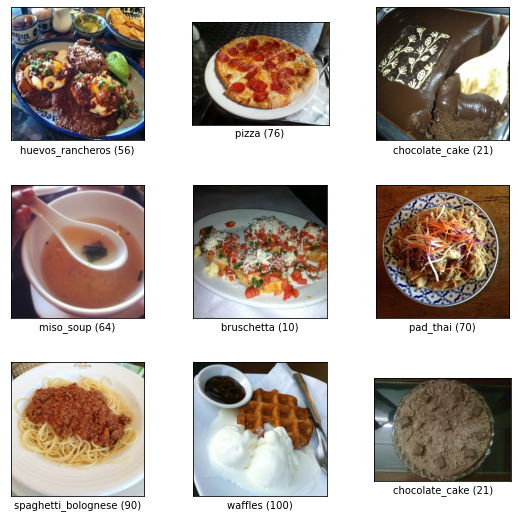

In [236]:
fig = tfds.show_examples(train_ds, ds_info)


In [259]:


def augment(image_label, seed):
    image, label = image_label
   # image, label = resize_and_rescale(image, label)
    image = tf.image.resize_with_crop_or_pad(image, INP_SIZE + 6, INP_SIZE + 6)
     
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
      # Random crop back to the original size
    image = tf.image.stateless_random_crop(
           image, size=[INP_SIZE, INP_SIZE, 3], seed=seed)
      # Random brightness
    image = tf.image.stateless_random_brightness(
             image, max_delta=0.5, seed=new_seed)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [260]:
rng = tf.random.experimental.Generator.from_seed(123, )
def f(x, y):
    seed = rng.make_seeds(2)[0]
    image, label = augment((x, y), seed)
    return image, label

In [261]:
INP_SIZE = 160
NUM_EPOCHS = 2
BATCH_SIZE = 32


def prepare(img, label):
    img =  tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
# augment
train_ds = train_ds.map(f)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

In [262]:
WEIGHT_DECAY = 0.001

base_model = tf.keras.applications.MobileNetV2(
        input_shape=(INP_SIZE, INP_SIZE, 3),
        include_top=False,
        weights='imagenet',
    )
base_model.trainable = True # Fine-tuning весов предобученной модели
#base_model.trainable = False # Заморозка весов предобученной модели
###  с заморозкой весов качество слабое

wd = tf.keras.regularizers.l2(WEIGHT_DECAY)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='softmax',kernel_regularizer=wd),
])

In [263]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#tensorboard_callback = tf.keras.callbacks.TensorBoard(
#    log_dir='logs/'+EXP_NAME, 
#    write_graph=False, update_freq=100, profile_batch=0)

In [264]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 101)               129381    
Total params: 2,387,365
Trainable params: 2,353,253
Non-trainable params: 34,112
_________________________________________________________________


In [14]:
# последующая тренировка модели
#model.load_weights('model_wh_09')

In [14]:
NUM_EPOCHS=4

In [16]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,)
    #callbacks=[tensorboard_callback])

Epoch 1/4
2130/2130 [==============================] - 518s 243ms/step - loss: 0.4796 - accuracy: 0.8952 - val_loss: 2.5525 - val_accuracy: 0.5246
Epoch 2/4
2130/2130 [==============================] - 518s 243ms/step - loss: 0.4582 - accuracy: 0.9013 - val_loss: 2.4229 - val_accuracy: 0.5420
Epoch 3/4
2130/2130 [==============================] - 515s 242ms/step - loss: 0.4516 - accuracy: 0.9033 - val_loss: 2.5257 - val_accuracy: 0.5396
Epoch 4/4
2130/2130 [==============================] - 515s 242ms/step - loss: 0.4341 - accuracy: 0.9081 - val_loss: 2.4532 - val_accuracy: 0.5432
Wall time: 34min 25s


In [18]:
model.save_weights('model_wh_09')

In [265]:
### проверка

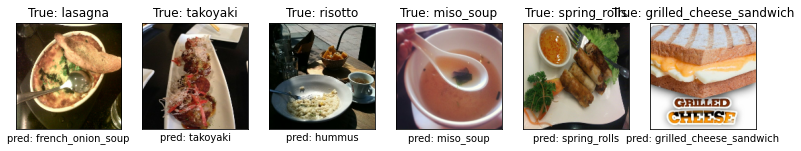

In [223]:
some_samples = [x for x in iter(tеst_ds.take(6))]

fig = plt.figure(figsize=(36, 16))
for j in range(len(some_samples)):
    ax = fig.add_subplot(6, 16, j+1)
    img_=((tf.cast(some_samples[0][0][j], tf.float32)+1)*127.)/255
    ax.imshow(img_)
    pred =model.predict_classes(some_samples[0][0][j][None, ...])[0]
    ax.set_title(f'True: {classes_name[some_samples[0][1][j].numpy()]}')
    ax.set_xlabel(f'pred: {classes_name[pred]}')
    plt.xticks([]), plt.yticks([])
plt.show()
